Original notebook from James A. Bednar. https://gist.github.com/jbednar/8911276f81f0224b4af524fd3435445f

# Datashader Clifford attractor app

[Datashader](http://datashader.org) renders data into images. 
[Clifford attractors](https://anaconda.org/jbednar/clifford_attractor/notebook) are a type of iterative equation that traces the path of a particle through a 2D space using functions of sine and cosine terms that make interesting "attractor" patterns (covering only some portions of the possible space, in certain shapes). Here we use Numpy and Pandas to calculate a dataframe consisting of ten million such locations, using Numba to make it 50X faster than bare Python. You can run this code yourself if you make a [conda](http://conda.pydata.org/miniconda.html) environment and run `conda install -c pyviz pyviz` first.

In my case I also had to do (`panel` was missing after the above command): `conda install -c pyviz panel `

In [1]:
import numpy as np, pandas as pd
from numba import jit
import param
from colorcet import palette
import datashader as ds
from datashader import transfer_functions as tf
from colorcet import kbc, fire

In [2]:
@jit
def clifford(x, y, a, b, c, d):
    return np.sin(a * y) + c * np.cos(a * x), \
           np.sin(b * x) + d * np.cos(b * y)

In [3]:
@jit
def trajectory(fn, x0, y0, a, b, c, d, n):
    x, y = np.zeros(n), np.zeros(n)
    x[0], y[0] = x0, y0
    for i in np.arange(n-1):
        x[i+1], y[i+1] = fn(x[i], y[i], a, b, c, d)
    return pd.DataFrame(dict(x=x,y=y))


We can visualize the resulting dataframe using Datashader, with colormaps from [Colorcet](http://colorcet.pyviz.org):

In [4]:
def plot(x0, y0, a, b, c, d, n=500000, cmap=kbc[::-1]):
    cvs = ds.Canvas(plot_width=300, plot_height=300)
    agg = cvs.points(trajectory(clifford, x0, y0, a, b, c, d, n), 'x', 'y')
    return tf.shade(agg, cmap=cmap)

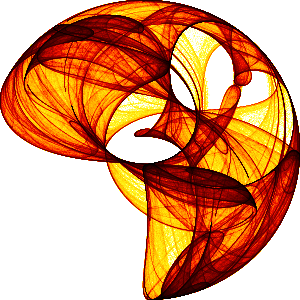

In [5]:
plot(0,0,1.7, 1.7, 0.6, 1.2, n = 10000000, cmap = fire[::-1])

We could call this function a single time with one set of parameters, as e.g. `clifford_plot(0, 0, 1.7, 1.7, 0.6, 1.2)`, but instead let's use [Panel](http://panel.pyviz.org) to make a simple dashboard that lets us try out all of them interactively. First we declare what parameters there are that we will want to vary, and what code to run when they do:

In [16]:
class Clifford(param.Parameterized):
    a = param.Number(1.7, bounds=(-2, 2))
    b = param.Number(1.7, bounds=(-2, 2))
    c = param.Number(0.6, bounds=(-2, 2))
    d = param.Number(1.2, bounds=(-2, 2))
    x0 = param.Number(0,  softbounds=(-2, 2), doc="Starting x value", precedence=-1)
    y0 = param.Number(0,  softbounds=(-2, 2), doc="Starting y value", precedence=-1)
    
    colormap = param.ObjectSelector("fire", precedence=0.7, 
        objects=['bgy', 'bmw', 'bmy','fire', 'gray', 'kbc', 'kgy'])
  
    Number_of_Points = param.ObjectSelector(500000, precedence=0.7, 
        objects=[500000, 1000000, 5000000, 10000000])

    def view(self):
            return plot(self.x0, self.y0, self.a, self.b, self.c, self.d, n = self.Number_of_Points,
                             cmap = palette[self.colormap][::-1])
    
c = Clifford(name="Clifford Attractor")

In [17]:
class CliffordExamples(param.Parameterized):
    x0 = param.Number(0,  softbounds=(-2, 2), doc="Starting x value", precedence=-1)
    y0 = param.Number(0,  softbounds=(-2, 2), doc="Starting y value", precedence=-1)
    
    examples = param.ObjectSelector("-1.9,   -1.9,   -1.9,   -1.0",
                                    objects= ["-1.9,   -1.9,   -1.9,   -1.0",
                                              "-1.4,    1.6,    1.0,    0.7",
                                              "1.7,    1.7,    0.6,    1.2",
                                              "1.7,    0.7,    1.4,    2.0",
                                              "-1.7,    1.8,   -1.9,   -0.4",
                                              "1.1,   -1.32,  -1.03,   1.54",
                                              "-1.9,   -1.9,   -1.9,   -1.0",
                                              "0.77,   1.99,  -1.31,  -1.45",
                                              "0.75,   1.34,  -1.93,   1.00",
                                              "-1.32,  -1.65,   0.74,   1.81",
                                              "1.10,  -0.90,   0.10,   0.20"
                                             ])
    
    colormap = param.ObjectSelector("kbc", precedence=0.7,
                                    objects=['bgy', 'bmw', 'bmy','fire', 'gray', 'kbc', 'kgy'])
  
    Number_of_Points = param.ObjectSelector(500000, precedence=0.7, 
        objects=[500000, 1000000, 5000000, 10000000])

    def view(self):
        vals = self.examples
        af, bf, cf, df = [float(s) for s in vals.split(",")]
        return plot(self.x0, self.y0, af, bf, cf, df, n = self.Number_of_Points,
                             cmap = palette[self.colormap][::-1])
    
cExamples = CliffordExamples(name="")

In [18]:
class Attractors(param.Parameterized):
    pick_One = param.ClassSelector(Clifford)
attrac = Attractors(name = "Attractors") 

And now we can make a panel with a logo, widgets for the parameters, and the result of calling the `view` method whenever any of the parameters change:

The **left panel**, for picking one kind of attractor **is not working** (yet). I'm a little bit rusty in `classes`, so probably I will not do it soon :(

In [19]:
import panel as pp
pp.extension()
logo  = "https://tinyurl.com/y9c2zn65/logo_stacked_s.png"
panel = pp.Row( pp.Column(logo, attrac), pp.Column(c.view, c), pp.Column(cExamples.view, cExamples))
panel

Row(name='Row00373', objects=[Column(name='Column00336', objects=[PNG(height=None, name='PNG00327', object='https://tinyurl.com/y9c2zn65/logo_stacked_s.png', sizing_mode=None, style=None, width=None), Param(default_precedence=1e-08, display_threshold=0, height=None, initializer=None, label_formatter=<class 'panel.util.default_label_formatter'>, name='Attractors', object=Attractors(name='Attractors', pick_One=None), show_labels=True, subpanel_layout=<class 'panel.layout.Row'>, width=300)]), Column(name='Column00357', objects=[ParamMethod(name='ParamMethod00337', object=<bound method Clifford.view of Clifford(Number_of_Points=500000, a=1.7, b=1.7, c=0.6, colormap='fire', d=1.2, name='Clifford Attractor', x0=0, y0=0)>), Param(default_precedence=1e-08, display_threshold=0, height=None, initializer=None, label_formatter=<class 'panel.util.default_label_formatter'>, name='Clifford Attractor', object=Clifford(Number_of_Points=500000, a=1.7, b=1.7, c=0.6, colormap='fire', d=1.2, name='Clifford Attractor', x0=0, y0=0), show_labels=True, subpanel_layout=<class 'panel.layout.Row'>, width=300)]), Column(name='Column00372', objects=[ParamMethod(name='ParamMethod00358', object=<bound method CliffordExamples.view of CliffordExamples(Number_of_Points=500000, colormap='kbc', examples='-1.9,   -1.9,   -1.9,   -1.0', name='', x0=0, y0=0)>), Param(default_precedence=1e-08, display_threshold=0, height=None, initializer=None, label_formatter=<class 'panel.util.default_label_formatter'>, name='', object=CliffordExamples(Number_of_Points=500000, colormap='kbc', examples='-1.9,   -1.9,   -1.9,   -1.0', name='', x0=0, y0=0), show_labels=True, subpanel_layout=<class 'panel.layout.Row'>, width=300)])])

In [20]:
panel.server_doc();